## Julian Stennett | CGS4144 Bioinformatics | Assignment 3

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA

In [3]:
# Load the dataset
df = pd.read_csv('output.csv')
df.head()

,Gene,ERR2239979,ERR2239980,ERR2239981,ERR2239982,ERR2239983,ERR2239984,ERR2239985,ERR2239986,ERR2239987,...,ERR2240041,ERR2240042,ERR2240043,ERR2240044,ERR2240045,ERR2240046,ERR2240047,ERR2240048,ERR2240049,ERR2240050
0,GTSE1,-0.974780,-1.098466,-0.096769,-0.810719,0.810700,0.781491,-0.063221,0.571952,1.025183,...,-0.395163,1.719113,-0.201687,-0.950950,0.787939,2.233017,1.397065,-0.739792,0.203013,0.617727
1,TTC38,-0.303871,1.027110,0.212347,1.178167,1.367981,0.660345,-0.226611,-0.531966,-0.797222,...,0.143982,0.270656,0.585510,0.434997,1.091644,1.599875,1.342389,0.033841,1.012071,1.357558
2,CDPF1,-0.310751,-0.421228,-0.780650,-0.376613,-0.861849,-0.669572,0.076419,1.241911,1.137093,...,-0.568306,-0.894833,-0.057907,-0.994663,0.596338,0.283011,0.900497,-0.352856,-0.600167,0.047482
3,PPARA,0.627432,0.318908,-0.161431,0.859589,-0.798180,-0.669031,-1.449027,0.033215,0.671936,...,-0.016897,3.868562,1.548431,-0.407325,-1.493562,0.159849,1.554370,0.065728,0.985354,0.374793
4,TRMU,-0.280341,1.518008,0.333855,0.096288,-0.202121,0.789890,0.733772,-0.162580,0.113229,...,-0.206097,0.229155,-0.107253,1.584477,1.460494,-0.191817,-0.380415,0.370317,1.307943,0.807296


In [4]:
# Transpose the dataframe to cluster columns instead of rows
df_T = df.set_index('Gene').T

# Compute similarity matrix
similarity_matrix = -pairwise_distances(df_T, metric='euclidean', squared=True)

In [5]:
# Perform Affinity Propagation clustering on transposed data
ap = AffinityPropagation(affinity='precomputed', random_state=42)
ap.fit(similarity_matrix)

# Assign cluster labels to each condition
df_T['Cluster'] = ap.labels_

# Save the cluster assignments
df_T[['Cluster']].to_csv('propagation.csv')

print("Condition cluster assignments have been saved to 'propagation.csv'.")

df_T[['Cluster']].head()


Condition cluster assignments have been saved to 'propagation.csv'.


Gene,Cluster
ERR2239979,0
ERR2239980,0
ERR2239981,0
ERR2239982,1
ERR2239983,1


Performing PCA for visualization...
Creating scatter plot...


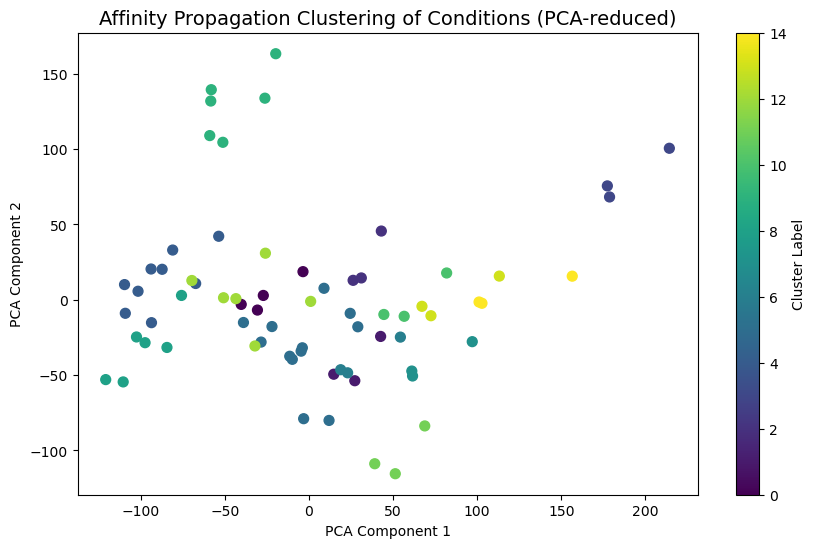

In [6]:
# Visualize the clusters using PCA
print("Performing PCA for visualization...")
pca = PCA(n_components=2)
df_T_pca = pca.fit_transform(df_T.drop('Cluster', axis=1))  # Drop 'Cluster' for PCA

# Create a scatter plot for PCA components and color-code by clusters
print("Creating scatter plot...")
plt.figure(figsize=(10, 6))
plt.scatter(df_T_pca[:, 0], df_T_pca[:, 1], c=df_T['Cluster'], cmap='viridis', s=50)

# Add labels and title
plt.title('Affinity Propagation Clustering of Conditions (PCA-reduced)', fontsize=14)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [7]:
from scipy.stats import chi2_contingency

# Function to sample the dataframe and apply Affinity Propagation clustering
def apply_affinity_propagation(df, percentage):
    # Sample the dataframe
    sample_size = int(percentage * len(df))
    sampled_df = df.sample(sample_size, random_state=42)
    
    # Remove non-numeric columns (like gene IDs) and only keep expression data
    numeric_data = sampled_df.select_dtypes(include=[np.number])
    
    # Compute similarity matrix using numeric data
    similarity_matrix = 1 - pairwise_distances(numeric_data.T, metric='correlation')
    
    # Perform Affinity Propagation clustering
    ap = AffinityPropagation(affinity='precomputed', random_state=42)
    ap.fit(similarity_matrix)
    
    # Return the cluster labels
    return ap.labels_

# Function to perform chi-squared test between two clustering results
def chi_squared_test(cluster1, cluster2):
    contingency_table = pd.crosstab(cluster1, cluster2)
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return chi2, p

# Main dataframe (assuming your dataframe is named df)
percentages = [0.1, 0.25, 0.5, 1.0]
cluster_labels = {}

# Apply Affinity Propagation to each sample size
for perc in percentages:
    cluster_labels[perc] = apply_affinity_propagation(df, perc)

# Perform pairwise chi-squared tests and store results in a table
results = []
for i in range(len(percentages)):
    for j in range(i+1, len(percentages)):
        chi2, p = chi_squared_test(cluster_labels[percentages[i]], cluster_labels[percentages[j]])
        results.append([f"{percentages[i]*100}% vs {percentages[j]*100}%", chi2, p])

results_df = pd.DataFrame(results, columns=['Comparison', 'Chi-squared', 'p-value'])
print(results_df)



        Comparison  Chi-squared        p-value
0   10.0% vs 25.0%   728.954545   1.458682e-70
1   10.0% vs 50.0%   778.055556   1.223314e-74
2  10.0% vs 100.0%   728.954545   1.458682e-70
3   25.0% vs 50.0%   878.299663   1.101902e-91
4  25.0% vs 100.0%   910.000000  7.415764e-102
5  50.0% vs 100.0%   878.299663   1.101902e-91


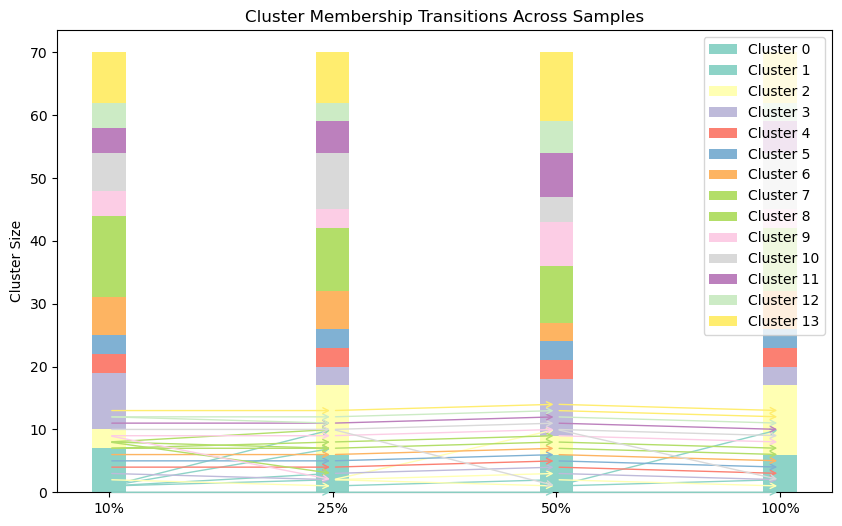

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assume cluster_labels is a dictionary where the keys are percentages (0.1, 0.25, 0.5, 1.0)
# and the values are the corresponding cluster labels from the Affinity Propagation step.
cluster_df = pd.DataFrame(cluster_labels)

def create_alluvial(cluster_df):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Define colors for clusters
    cluster_colors = plt.cm.Set3(np.linspace(0, 1, len(np.unique(cluster_df.values))))

    # Plot stacked bars for each clustering result
    bar_width = 0.15
    x = np.arange(len(cluster_df.columns))

    # Prepare data for plotting
    for idx, cluster_col in enumerate(cluster_df.columns):
        clusters, counts = np.unique(cluster_df[cluster_col], return_counts=True)
        bottom = np.zeros(len(clusters))

        for i, (cluster, count) in enumerate(zip(clusters, counts)):
            ax.bar(x[idx], count, bar_width, bottom=bottom, color=cluster_colors[i], label=f'Cluster {cluster}' if idx == 0 else "")
            bottom += count

        # Draw transitions (ribbons) between bars to simulate flow
        if idx < len(cluster_df.columns) - 1:
            current_clusters = cluster_df[cluster_col]
            next_clusters = cluster_df[cluster_df.columns[idx + 1]]
            
            for current_cluster in np.unique(current_clusters):
                for next_cluster in np.unique(next_clusters):
                    # Calculate flow
                    flow = len(cluster_df[(current_clusters == current_cluster) & (next_clusters == next_cluster)])
                    if flow > 0:
                        # Coordinates for arrow
                        ax.annotate(
                            '', xy=(x[idx+1], next_cluster), xytext=(x[idx], current_cluster),
                            arrowprops=dict(arrowstyle='->', lw=1, color=cluster_colors[current_cluster % len(cluster_colors)])
                        )

    ax.set_xticks(x)
    ax.set_xticklabels([f'{int(p * 100)}%' for p in cluster_df.columns])
    ax.set_ylabel('Cluster Size')
    ax.set_title('Cluster Membership Transitions Across Samples')

    plt.legend(loc='upper right')
    plt.show()

# Call the function to create and display the alluvial diagram
create_alluvial(cluster_df)


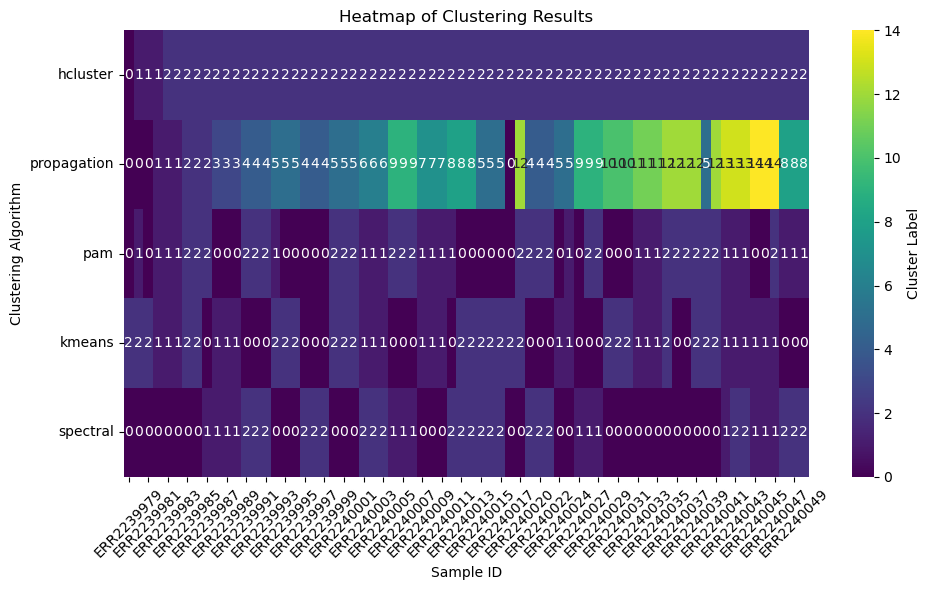

In [66]:
# Load the clustering results
clusterType1 = pd.read_csv("spitulnik,hcluster_results.csv", index_col=0)
clusterType2 = pd.read_csv("propagation.csv", index_col=0)
clusterType3 = pd.read_csv("pam_clustering_results_k3.csv", index_col=0)
clusterType4 = pd.read_csv("kmeans_results.csv", index_col=0)
clusterType5 = pd.read_csv("grant, a. spectral_results.csv", index_col=0)

# Rename the cluster columns for clarity
clusterType1.columns = ['hcluster']
clusterType2.columns = ['propagation']
clusterType3.columns = ['pam']
clusterType4.columns = ['kmeans']
clusterType5.columns = ['spectral']

# Combine the clustering results into a single DataFrame
combined = pd.concat([clusterType1, clusterType2, clusterType3, clusterType4, clusterType5], axis=1)

# Fill missing values with a specific value (e.g., -1)
combined.fillna(-1, inplace=True)

# Convert clusters to categorical codes for heatmap visualization
for col in combined.columns:
    combined[col] = combined[col].astype('category').cat.codes

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(combined.T, cmap='viridis', annot=True, cbar_kws={'label': 'Cluster Label'})
plt.title("Heatmap of Clustering Results")
plt.xlabel("Sample ID")
plt.ylabel("Clustering Algorithm")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
